In [2]:
import networkx
import pandas as pd
import numpy as np
import scipy.sparse as sp
from collections import defaultdict
import itertools
import matplotlib.pyplot as plt

In [165]:
%matplotlib inline

# MLE

A simple generative model for reads:

>Pick a species $j$ at random according to its prevalence $q_j$ and choose a random
read $r$ from that species.

We'd like to know the posterior probability $\mathbb{P}(q_1,\dots,q_n | \text{reads}).$

Let $r_{ij} = 1$ if read i aligns to species j
(with quality above some threshold) then otherwise set $r_{ij} = 0$.

Then the log likelihood of seeing a given set of reads is (up to an additive constant):


$$\mathcal{L}(r_1,\dots,r_N) = \sum_{i = 1}^N \log(\sum_{j = 1}^n r_{ij}q_j)$$

The maximum posterior probability can be computed by maximizing this log likelihood.


Let's say you had 100, 10, and 10 unique reads, plus 40 reads mapping to just species 1 and 2, plus 30 reads mapping to all 3 species.

| n   | species 1 | species 2 | species 3 |
|-----|-----------|-----------|-----------|
| 100 |     X     |           |           |
| 10  |           |     X     |           |
| 10  |           |           |     X     |
| 40  |     X     |     X     |           |
| 30  |     X     |     X     |     X     |

The likelihood is then

$$100\log(q_1) + 10\log(q_2) + 10\log(q_3) + 40\log(q_1 + q_2) + 30\log(q_1 + q_2 + q_3).$$

In our current model this would give counts of 130, 40, and 20, assuming each multimapped read was assigned randomly.

The maximum likelihood (subject to the constraint $q_1 + q_2 + q_3 = 1$)
is achieved at probabilities $q_1 = \frac{150}{176}, q_2 = \frac{15}{176}, q_3 = \frac{11}{176}$.

| percent   | species 1 | species 2 | species 3 |
|-----------|-----------|-----------|-----------|
| read ratio |     68%   |     21%    |   11%        |
| posterior probability  |     85%      |     9%     |  6%   |

In [175]:
def notes_eg():
    D = sp.diags([100, 10, 10, 40, 30])
    X_dense = [[1, 0, 0],
               [0, 1, 0],
               [0, 0, 1],
               [1, 1, 0],
               [1, 1, 1]]
    X = sp.csr_matrix(X_dense)
    q_exact_optimum = np.array([150/176,15/176,11/176])
    return X, D, q_exact_optimum

In [176]:
def two_species_eg():
    D = sp.diags([1, 1])
    X_dense = [[1, 1],
               [1, 0]]
    X = sp.csr_matrix(X_dense)
    q_exact_optimum = np.array([1,0])
    return X, D, q_exact_optimum

In [363]:
def read_proportion(X, D):
    normalizer = sp.diags((1/X.sum(axis=1)).A1)
    read_proportion = normalizer.dot(D.dot(X)).sum(axis = 0).A1
    read_proportion = read_proportion/read_proportion.sum()
    return read_proportion

In [139]:
def grad(X, D, q):
    return X.T.dot(D.dot(1/X.dot(q)))
def proj_grad(X, D, q):
    g = grad(X,D,q)
    return g - g.mean()

In [166]:
def proj_grad_descent(alpha, q_0, proj_grad_fun, max_iter):
    iterates = np.zeros((max_iter, len(q_0)))
    q = q_0
    for i in range(max_iter):
        iterates[i,:] = q
        x = q + alpha*proj_grad_fun(q)
        x = x*(x > 0)
        q = x/x.sum()
    return q, iterates

In [364]:
def test_eg(X, D, q_exact_optimum):
    n_read_types, n_species = X.shape
    alpha = 1e-1/D.sum()
    max_iter = 1000
    
    q_0 = read_proportion(X,D)

    print(f"Testing example with {n_species} species, {n_read_types} read types and {D.sum()} reads.")
    q_opt, iterates = proj_grad_descent(alpha, q_0, lambda x: proj_grad(X, D, x), max_iter)
    if(np.allclose(q_opt, q_exact_optimum)):
        print("Test passes.")
    else:
        print("Grad descent did not converge to the optimum in {max_iter} steps.")

In [365]:
test_eg(*two_species_eg())

Testing example with 2 species, 2 read types and 2.0 reads.
Test passes.


In [366]:
test_eg(*notes_eg())

Testing example with 3 species, 5 read types and 190.0 reads.
Test passes.


In [241]:
def run_with_defaults(X, D):
    n_read_types, n_species = X.shape
    alpha = 1e-2/D.sum()
    q_0 = np.ones(n_species)/n_species
    max_iter = 1000

    q_opt, iterates = proj_grad_descent(alpha, q_0, lambda x: proj_grad(X, D, x), max_iter)
    return q_opt, iterates

In [358]:
X, D, q_exact_optimum = two_species_eg()
X, D, q_exact_optimum = notes_eg()

In [367]:
n_read_types, n_species = X.shape
alpha = 1e-1/D.sum()

q_0 = read_proportion(X, D)

q_opt, iterates = proj_grad_descent(alpha, q_0, lambda x: proj_grad(X, D, x), 100)

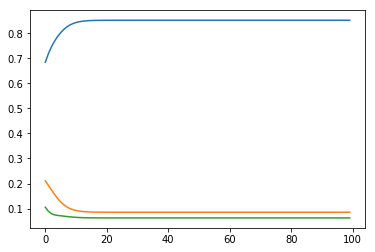

In [368]:
plt.plot(iterates)

# Real Data

In [199]:
df = pd.read_csv('/Users/josh/src/idinf/retained-NR.retained-NT.filter.unmapped.cdhit.ZINTER_TRIZ_100K_CFU.1000.m8.lca_forJB',
                sep = '\t',dtype = {'tax_id': object, 'qseqid':object})

#df = pd.read_csv('/Users/josh/src/idinf/SRR172902-FAUHGnt-n1000.m8.v2_forJB', sep = '\t',dtype = {'tax_id': object, 'qseqid':object})

In [205]:
df.head(5)

,qseqid,bitscore,tax_id
6638466,NR:0:NT:0:K00153:466:HMJ2TBBXX:8:1101:10571:48...,46.6,5061
6638465,NR:0:NT:0:K00153:466:HMJ2TBBXX:8:1101:10571:48...,74.0,5061
6638467,NR:0:NT:0:K00153:466:HMJ2TBBXX:8:1101:10571:48...,83.1,5061
6638468,NR:0:NT:0:K00153:466:HMJ2TBBXX:8:1101:10571:48...,74.0,5061
3754726,NR:0:NT:0:K00153:466:HMJ2TBBXX:8:1101:13748:13...,167.4,100272


In [201]:
df = df.dropna()
df = df.sort_values('qseqid')

bitscore_cutoff = 30
adjacency = defaultdict(int)
reads_processed = 0

seq = None
tax_ids = []

for tup in df.itertuples():
    if tup.bitscore < bitscore_cutoff:
        continue
    if tup.qseqid == seq:
        tax_ids.append(tup.tax_id)
    else:
        if reads_processed > 0:
            utax_ids = np.unique(tax_ids)
            multi_edge = "-".join(sorted(utax_ids))
            adjacency[multi_edge] += 1
        reads_processed += 1
        seq = tup.qseqid
        tax_ids = [tup.tax_id]
        if reads_processed % 100000 == 0:
            print(f'Processed {reads_processed} reads')

Processed 100000 reads
Processed 200000 reads
Processed 300000 reads
Processed 400000 reads
Processed 500000 reads
Processed 600000 reads
Processed 700000 reads
Processed 800000 reads
Processed 900000 reads
Processed 1000000 reads
Processed 1100000 reads
Processed 1200000 reads
Processed 1300000 reads
Processed 1400000 reads


In [223]:
species = df['tax_id'].unique()

species_to_int = {s: i for i, s in enumerate(species)}
adj_to_int = {adj:i for i, adj in enumerate(adjacency)}

X = sp.dok_matrix((len(adjacency), len(species)), dtype = np.int32)
D = sp.dok_matrix((len(adjacency), len(adjacency)), dtype = np.int32)
                  
for a, v in adjacency.items():
    i = adj_to_int[a]
    D[i,i] = v
    
    tax_ids = a.split("-")
    for tax in tax_ids:
        j = species_to_int[tax]
        X[i,j] = 1
    
X = sp.csr_matrix(X)
D = sp.csr_matrix(D)

In [234]:
X.shape

(10174, 35731)

In [336]:
n_read_types, n_species = X.shape
alpha = 1e-6/D.sum()

# Initialize by splitting reads amount mapped species
normalizer = sp.diags((1/X.sum(axis=1)).A1)
read_proportion = normalizer.dot(D.dot(X)).sum(axis = 0).A1
read_proportion = read_proportion/read_proportion.sum()
q_0 = read_proportion
max_iter = 10000

q_opt, iterates = proj_grad_descent(alpha, q_0, lambda x: proj_grad(X, D, x), max_iter)

In [352]:
k = 1000
ind = np.argpartition(q_opt, -k)[-k:]

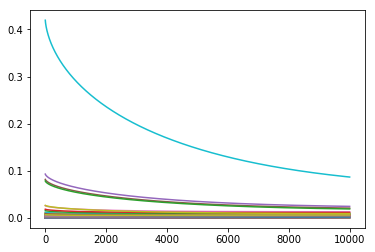

In [346]:
plt.plot(iterates[:,ind])

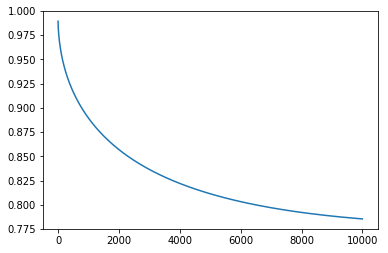

In [353]:
plt.plot(iterates[:,ind].sum(axis = 1))

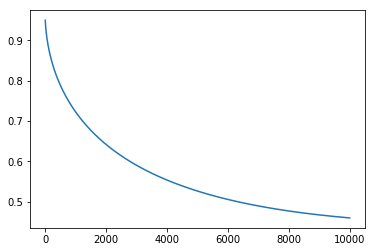

In [351]:
plt.plot(iterates[:,ind].sum(axis = 1))

Something strange is happening, where weight is getting shunted away from the most populous species into the fat tail.

In [27]:
cluster_membership = {tax: i for i, tax in enumerate(np.unique(df['tax_id']))}

In [66]:
graph = networkx.Graph()

for tax in cluster_membership:
    graph.add_node(tax)

for e in adjacency:
    tax_ids = e.split("-")
    if len(tax_ids) > 10:
        continue
    for c in itertools.combinations(tax_ids, 2):
        graph.add_edge(*c)

In [67]:
components = [c for c in networkx.connected_components(graph)]

In [68]:
components = sorted(components, key = lambda x: -len(x))

In [69]:
for c in components[0:10]:
    print(len(c))

3348
19
13
10
10
10
10
9
9
9


In [65]:
sum([adjacency[e] for e in adjacency if len(e.split("-")) > 10])/sum(adjacency.values())

0.019605316458993202

In [63]:
sum([adjacency[e] for e in adjacency if len(e.split("-")) > 50])/sum(adjacency.values())

0.004854891321856058

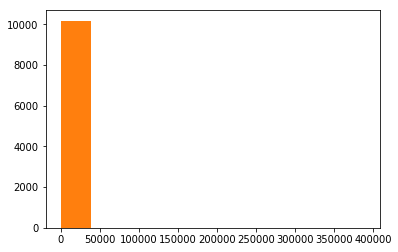

In [41]:
plt.hist(list(adjacency.values()))
plt.show()

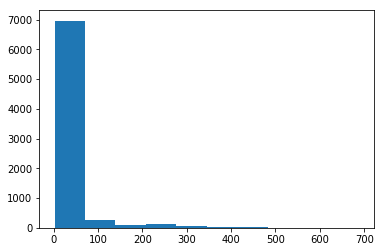

In [43]:
multimapping = [len(a.split('-')) for a in adjacency]

plt.hist([m for m in multimapping if m > 1])
plt.show()

In [35]:
for k in sorted(adjacency, key = lambda x: - len(x.split('-'))):
    print(adjacency[k])

1
1
1
1
2
1
1
2
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
3
1
1
2
1
1
1
1
1
1
1
1
1
1
1
2
2
1
1
1
1
1
1
1
1
1
1
2
1
2
1
1
1
2
1
1
1
1
1
1
3
1
7
4
4
1
1
43
1
1
2
8
1
2
4
1
1
1
1
1
3
1
1
1
1
1
1
5
70
3
1
1
1
2
1
1
4
5
1
3
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
6
1
11
2
1
1
1
1
2
1
1
1
2
6
2
2
1
1
1
2
1
1
1
1
1
1
1
1
2
48
2
1
11
1
2
3
1
1
1
1
3
1
5
1
7
2
1
1
1
6
3
2
16
6
2
1
1
2
1
60
14
1
1
1
1
1
1
56
10
1
2
2
1
2
1
1
12
12
3
1
3
1
1
1
1
1
1
1
2
1
1
1
2
1
1
2
1
1
1
2
1
1
5
1
1
2
6
3
1
1
1
1
1
1
4
15
7
3
1
58
1
1
1
1
5
1
1
1
4
1
1
10
1
2
1
1
1
1
1
1
1
1
1
2
1
1
3
1
2
1
2
1
2
2
4
2
6
1
1
2
1
1
1
1
2
1
1
1
1
1
1
1
3
1
1
2
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
4
1
1
1
1
1
2
1
1
3
5
1
2
1
12
1
1
1
2
1
1
1
2
1
1
17
1
1
92
1
1
1
2
1
1
1
24
2
1
2
1
139
5
1
1
1
8
1
1
1
1
25
2
10
4
2
1
1
1
4
2
81
5
1
1
1
53
1
1
125
173
2
1
3
1
2
1
1
3
1
309
35
1
1
1
5
2
3
3
1
32
1
2
1
1
28
81
13
1
66
80
1
17
1
1
30
1
1
3
1
6
1
2
1
9
1
2
1
1
1
1
2
1
1
1
1
1
1
1
1
2
2
1
1
1
2
1
1
1
5
31
4
1
1
2
1
1

2
19
16
1
1
1
1
11
1
1
2
14
1
2
1
2
7
3
90
5
12
1
1
4
47
3
5
74
1
1
29
8
2
1
1
33
1
3
1
1
5
19
27
1
15
1
12
1
1
2
30
1
1
3
1
1
1
6
2
10
35
26
3
2
1
20
9
249
75
40
16
5
1
1
1
1
1
1
1
4
1
1
5
1
2
14
2
6
1
1
1
6
1
1
5
1
3
1
2
1
1
18
1
2
1
1
1
1
1
1
4
12
2
1
2
3
1
1
1
1
4
4
23
3
38
1
5
2
2
7
1
7
1
15
1
2
1
1
1
1
3
4
14
38
1
3
8
2
4
3
4
17
20
1
1
1
1
2
3
2
2
1
1
1
1
2
1
2
2
1
2
1
3
1
1
6
2
3
3
1
2
2
1
1
3
1
139
2
1
7
1
1
1
2
2
5
1
4
6
22
1
1
1
14
1
5
1
4
1
2
4
1
6
3
2
3
3
2
2
1
1
3
1
26
1
2
1
1
2
1
3
2
5
1
1
9
1
23
3
14
1
16
16
3
1
1
1
1
1
1
1
1
2
1
1
1
7
1
8
1
1
1
2
1
1
1
2
2
47
2
3
1
2
1
27
3
2
1
2
1
1
1
1
1
2
6
1
1
1
83
1
1
2
9
2
1
1
6
1
1
1
1
1
20
2
1
1
14
1
1
1
1
1
2
2
1
2
1
4
1
5
2
5
1
3
2
1
1
4
1
2
3
1
2
1
1
1
2
1
2
2
1
5
1
1
1
1
1
3
1
1
1
1
1
3
1
1
1
1
3
2
2
1
1
1
12
2
1
2
1
3
3
2
1
10
2
16
1
2
1
2
1
2
2
2
3
4
1
5
572
1
28
40
39
1
2
2
1
14
16
1
7
6
4
2
1
1
1
2
4
1
2
1
1
1
1
1
8
47
1
8
13
2
4
10
1
1
2
3
3
6
2
1
1
1
2
6
1
1
3
1
1
19
1
2
1
3
4
1
1
1
1
1
1
1
11
11
2
3
1
2
1
3
2
2
4
2
1


2
3
71
5
4
2
6
5
4
4
9
78
15
4
9676
63
1
3
2
12
15
26
11
12
14
18
1
1165
5
25
509
2
13
11
4
1
5
3
32
26
23
1
10
2
3
1
1
2
2
1
11
8
1
20
3
4
42
8
69
3
34
37
1
16
11
1
24
2
25
1
19
2
2
7
23
4
2
2
49
1
3
77
1
10
5
9
3
3
11
7
3
2
2
3
1
2
1
1
1
1
2
1
3
2
8
3
45
1
1
1
3
6
1
1
3
1
1
3
2
10
1
1
1
3
3
1
1
1
5
1
1
1
1
4
5
1
1
2
1
5
2
7
2
2
1
3
6
1
1
1
2
2
1
3
2
1
1
1
1
1
1
1
1
11
5
1
1
1
1
1
93
1
1
2
2
9
7
1
1
1
5
1
3
1
1
6
1
1
1
2
2
6
2
1
31
1
24
25
9
1
9
9
2
2
6
24
1
1
1
53
14
1
39
3
1
2
1
1
1
32
61
70
5
6
6
6
5
6
8
3
42
1
1
11
9
4
2
1
22
12
1
3
20
47
1
1
5
10
4
1
10
6
3
6
2
2
9
15
4
4
3
1
1
11
3
1
13
2
12
1
21
7
1
3
4
4
1
2
1
23
18
17
2
3
9
1
7
1
4
1
3
1
5
3
12
13
3
1
1
1
1
9
1
33
1
1
26
10
2
1
59
17
8
1
35
1
5
1
18
54
8
2
5
1
6
5
2
7
6
5
1
8
4
21
7
2
6
6
3
6
1
1
1
2
1
2
23
1
2
2
7
1
8
2
2
1
3
3
18
1
1
1
1
2
28
80
3
35
42
8
47
1
2
4
2
1
3
16
6
8
33
1
2
1
1
4
2
28
9
11
2
1
3
5
6
8
5
4
2
5
1
3
2
14
1
18
11
13
1
1
6
10
4
34
18
4
13
7
1
2
1
45
1
21
15
9
19
2
6
8
27
5
1
1
4
1
1
1
2
6
4
2
5
1
3
1
6

In [ ]:
bigraph = networkx.Graph()

for tax in cluster_membership:
    graph.add_node(tax)

for e in adjacency:
    tax_ids = e.split("-")
    for c in itertools.combinations(tax_ids, 2):
        graph.add_edge(*c)

In [ ]:
df.groupby('qseqid').

Whoa there seems to be a __giant__ component

In [44]:
len(adjacency)

36514

In [50]:
max([len(e.split("-")) for e in adjacency])

857

In [52]:
[e for e in adjacency if len(e.split("-")) > 800]

['10036-1007537-1007538-1008992-10116-101201-101833-102133-102152-102153-1029637-1029639-1029640-1029642-1035709-1035733-1035737-1035740-1042310-1048777-1052595-1052596-1052597-1052598-1052599-1052600-1052601-1052602-1055687-106604-106611-106612-106614-106971-1076682-1090670-1091319-1092445-1093918-1093919-1110378-1112871-1128039-1128040-1128045-1128046-1128047-1128048-1128050-1128053-1128054-1128055-1128056-1128057-1128058-1128064-1128065-1128067-1128975-1130059-1133977-1147124-1147125-1155072-1168815-1168816-1177634-1177636-118295-118296-118303-119062-119491-120119-120361-1215326-1215327-123563-1235838-1235839-1243990-1245209-1247385-1249021-125568-125569-128137-1282795-1284600-1287793-1287794-129196-129197-129198-1292101-1294007-1294008-1295330-1296588-1296589-1317683-1328813-1328814-1331594-1331598-1331600-1331601-133222-1334102-1334104-1343677-1343679-134751-136605-136606-136607-1380987-1380988-1381106-1381108-1386861-1386862-1386865-1386868-1386954-1386955-1386956-1386958-1386959

In [106]:
df[df['qseqid'] == 'NR:0:NT:1211:K00153:466:HMJ2TBBXX:8:1109:21897:30749/2']

,qseqid,bitscore,tax_id
1352345,NR:0:NT:1211:K00153:466:HMJ2TBBXX:8:1109:21897...,39.8,259957
1352346,NR:0:NT:1211:K00153:466:HMJ2TBBXX:8:1109:21897...,26.1,259957
1352351,NR:0:NT:1211:K00153:466:HMJ2TBBXX:8:1109:21897...,58.0,259957
1352347,NR:0:NT:1211:K00153:466:HMJ2TBBXX:8:1109:21897...,17.0,259957
1352348,NR:0:NT:1211:K00153:466:HMJ2TBBXX:8:1109:21897...,3.3,259957
1352352,NR:0:NT:1211:K00153:466:HMJ2TBBXX:8:1109:21897...,28.4,259957
1352350,NR:0:NT:1211:K00153:466:HMJ2TBBXX:8:1109:21897...,26.1,259957
1352349,NR:0:NT:1211:K00153:466:HMJ2TBBXX:8:1109:21897...,74.0,259957
